In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
df = pd.read_csv('monthly_milk_production.csv', index_col='Date',parse_dates= True)
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

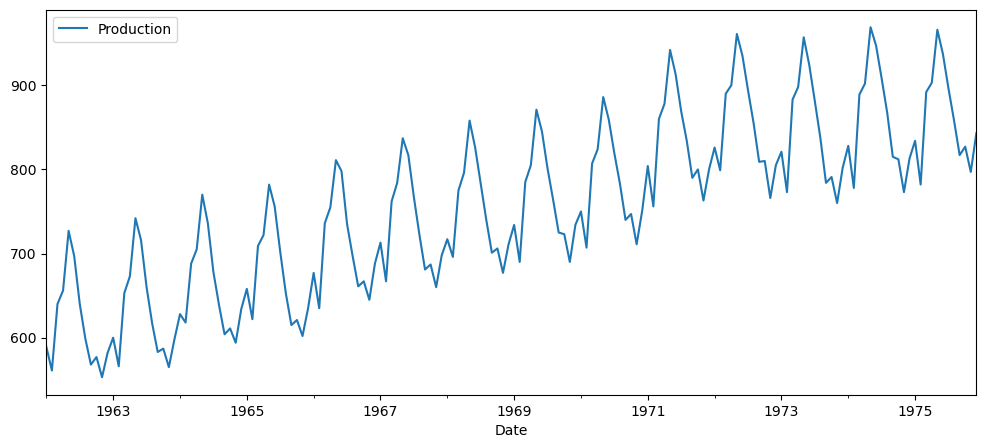

In [18]:
df.plot(figsize=(12,5))

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

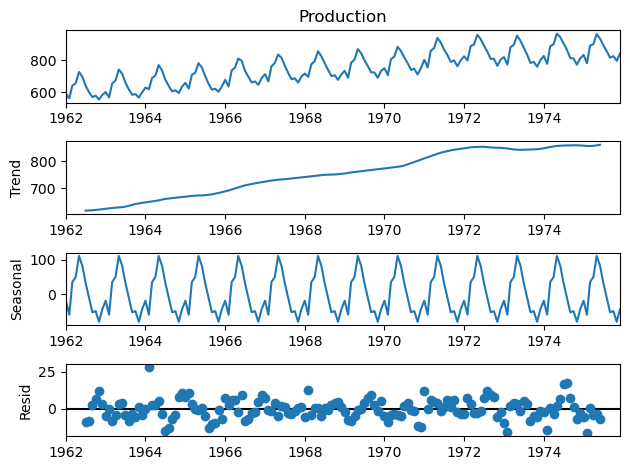

In [24]:
results = seasonal_decompose(df['Production'])
results.plot();

In [28]:
train = df.iloc[:156]
test = df.iloc[156:]

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [30]:
df.head(), df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [42]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [43]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [47]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [49]:
#define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=n_input, batch_size=1)

In [59]:
X,y = generator[0]

print(f'Given the array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [60]:
X.shape,y.shape

((1, 3, 1), (1, 1))

In [73]:
#define generator
n_input = 12
generator = TimeseriesGenerator(scaled_train,scaled_train, length=n_input, batch_size=1)

In [74]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [75]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [76]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 1s 2ms/step - loss: 0.0393 - accuracy: 0.0069
Epoch 2/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0220 - accuracy: 0.0069
Epoch 3/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0222 - accuracy: 0.0069
Epoch 4/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0152 - accuracy: 0.0069
Epoch 5/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 0.0069
Epoch 6/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.0069
Epoch 7/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0070 - accuracy: 0.0069
Epoch 8/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 0.0069
Epoch 9/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0043 - accuracy: 0.0069
Epoch 10/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.0069

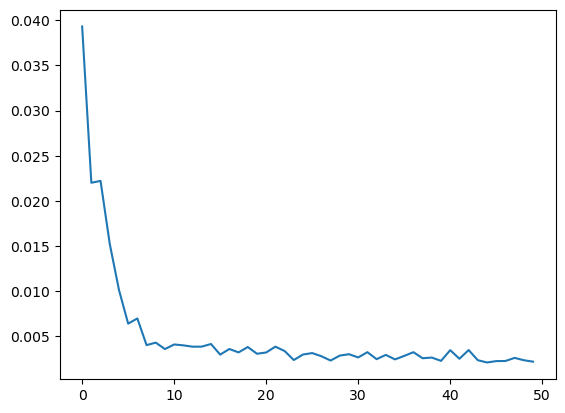

In [78]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [84]:
last_train_batch = scaled_train[-12:]
last_train_batch.shape

(12, 1)

In [85]:
last_train_batch = last_train_batch.reshape(1,n_input,n_features)
last_train_batch.shape

(1, 12, 1)

In [94]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 16ms/step


array([[0.69114524]], dtype=float32)

In [95]:
scaled_test[0]

array([0.67548077])

In [96]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)):
    curr_pred = model.predict(current_batch)[0]
    
    test_predictions.append(curr_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[curr_pred]],axis=1)

1/1 [==============================] - 0s 16ms/step


In [97]:
test_predictions

[array([0.69114524], dtype=float32),
 array([0.6747081], dtype=float32),
 array([0.86390394], dtype=float32),
 array([0.9406047], dtype=float32),
 array([1.0540799], dtype=float32),
 array([1.0371193], dtype=float32),
 array([0.961327], dtype=float32),
 array([0.852566], dtype=float32),
 array([0.7406637], dtype=float32),
 array([0.6982153], dtype=float32),
 array([0.6464759], dtype=float32),
 array([0.6919451], dtype=float32)]

In [98]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [118]:
true_predictions = scaler.inverse_transform(test_predictions)

AttributeError: 'function' object has no attribute 'copy'

In [108]:
true_predictions.shape

(12, 1)

In [119]:

test  = test.copy()
test.loc[:, 'Predictions'] = true_predictions


AttributeError: 'function' object has no attribute 'copy'

In [124]:
 test.head()

AttributeError: 'function' object has no attribute 'head'